<a href="https://colab.research.google.com/github/dede0702/Streamlit-Wildfire-Risk-Prediction-Project/blob/main/gs_fire_analysis_brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Solution: Análise e Previsão de Focos de Incêndio no Brasil



```
1.1. Carregamento e Limpeza dos Dados
```



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [ ]:
# Load the dataset
# The file has a BOM (Byte Order Mark) at the beginning of the header if not handled by encoding
file_path = 'all_dashboard-fires-month-02-06-2025-22_23_57.csv'
try:
    # Use encoding='utf-8-sig' to handle potential BOM
    # The first column name in the file has a BOM character if you inspect it raw.
    # Pandas might handle it, or we might need to rename df.columns[0]
    df = pd.read_csv(file_path, sep=';', encoding='utf-8-sig')
except FileNotFoundError:
    print(f"Arquivo '{file_path}' não encontrado. Certifique-se de que está no diretório correto.")
    exit()

In [ ]:
# Initial Data Inspection
print("--- Informações Iniciais do DataFrame ---")
df.info()

--- Informações Iniciais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9292 entries, 0 to 9291
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     9292 non-null   object
 1   class    9292 non-null   object
 2   focuses  9292 non-null   int64 
 3   uf       9292 non-null   object
dtypes: int64(1), object(3)
memory usage: 290.5+ KB


In [ ]:
# Clean column names (remove potential BOM from first column and extra spaces)
df.columns = df.columns.str.strip()
if df.columns[0].startswith('\ufeff'): # Check for BOM
    df.rename(columns={df.columns[0]: df.columns[0].replace('\ufeff', '')}, inplace=True)

print("\n--- Nomes das Colunas Após Limpeza Inicial ---")
print(df.columns)


--- Nomes das Colunas Após Limpeza Inicial ---
Index(['date', 'class', 'focuses', 'uf'], dtype='object')


In [ ]:
print("\n--- Primeiras 5 Linhas ---")
print(df.head())


--- Primeiras 5 Linhas ---
      date                                      class  focuses  \
0  2025/01  Fogo em áreas de desmatamento consolidado       31   
1  2025/01      Fogo em áreas de desmatamento recente       11   
2  2025/01          Fogo em áreas de vegetação nativa       11   
3  2025/02  Fogo em áreas de desmatamento consolidado       29   
4  2025/02      Fogo em áreas de desmatamento recente        3   

                  uf  
0  RIO GRANDE DO SUL  
1  RIO GRANDE DO SUL  
2  RIO GRANDE DO SUL  
3  RIO GRANDE DO SUL  
4  RIO GRANDE DO SUL  


In [ ]:
# Check for missing values
print("\n--- Valores Ausentes por Coluna ---")
print(df.isnull().sum())
# If any NaNs, decide on a strategy (e.g., drop, impute)
# For 'focuses', if NaN, it's problematic. Let's assume they are valid numbers or drop rows.
df.dropna(inplace=True) # Simple strategy: drop rows with any NaNs


--- Valores Ausentes por Coluna ---
date       0
class      0
focuses    0
uf         0
dtype: int64


In [ ]:
# Data Type Conversion and Feature Engineering
# Convert 'date' to datetime and extract Year and Month
df['date'] = pd.to_datetime(df['date'], format='%Y/%m')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
# Convert 'focuses' to numeric (it should be, but good to ensure)
df['focuses'] = pd.to_numeric(df['focuses'], errors='coerce')
df.dropna(subset=['focuses'], inplace=True) # Drop if conversion failed
df['focuses'] = df['focuses'].astype(int)

In [ ]:
# Inspect categorical columns
print("\n--- Valores Únicos em 'class' ---")
print(df['class'].unique())
print(f"Número de classes únicas: {df['class'].nunique()}")

print("\n--- Valores Únicos em 'uf' (Estados) ---")
print(df['uf'].unique())
print(f"Número de UFs únicas: {df['uf'].nunique()}")


--- Valores Únicos em 'class' ---
['Fogo em áreas de desmatamento consolidado'
 'Fogo em áreas de desmatamento recente'
 'Fogo em áreas de vegetação nativa' 'Fogo em outras áreas']
Número de classes únicas: 4

--- Valores Únicos em 'uf' (Estados) ---
['RIO GRANDE DO SUL' 'MATO GROSSO' 'MATO GROSSO DO SUL' 'ALAGOAS' 'BAHIA'
 'ESPÍRITO SANTO' 'GOIÁS' 'MINAS GERAIS' 'PARANÁ' 'PARAÍBA' 'PERNAMBUCO'
 'RIO DE JANEIRO' 'RIO GRANDE DO NORTE' 'SANTA CATARINA' 'SERGIPE'
 'SÃO PAULO' 'CEARÁ' 'PIAUÍ' 'MARANHÃO' 'RONDÔNIA' 'TOCANTINS' 'PARÁ'
 'DISTRITO FEDERAL' 'ACRE' 'AMAPÁ' 'AMAZONAS' 'RORAIMA']
Número de UFs únicas: 27


In [ ]:
print("\n--- DataFrame Após Limpeza e Transformações ---")
df.info()
print(df.head())


--- DataFrame Após Limpeza e Transformações ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9292 entries, 0 to 9291
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     9292 non-null   datetime64[ns]
 1   class    9292 non-null   object        
 2   focuses  9292 non-null   int64         
 3   uf       9292 non-null   object        
 4   year     9292 non-null   int32         
 5   month    9292 non-null   int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 363.1+ KB
        date                                      class  focuses  \
0 2025-01-01  Fogo em áreas de desmatamento consolidado       31   
1 2025-01-01      Fogo em áreas de desmatamento recente       11   
2 2025-01-01          Fogo em áreas de vegetação nativa       11   
3 2025-02-01  Fogo em áreas de desmatamento consolidado       29   
4 2025-02-01      Fogo em áreas de desmatamento recente        3



```
1.2. Análise Exploratória dos Dados (EDA)
```



In [ ]:
# Descriptive statistics for 'focuses'
print("\n--- Estatísticas Descritivas para 'focuses' ---")
print(df['focuses'].describe())


--- Estatísticas Descritivas para 'focuses' ---
count    9292.000000
mean      149.515174
std       453.655642
min         1.000000
25%         4.000000
50%        18.000000
75%        83.250000
max      6622.000000
Name: focuses, dtype: float64


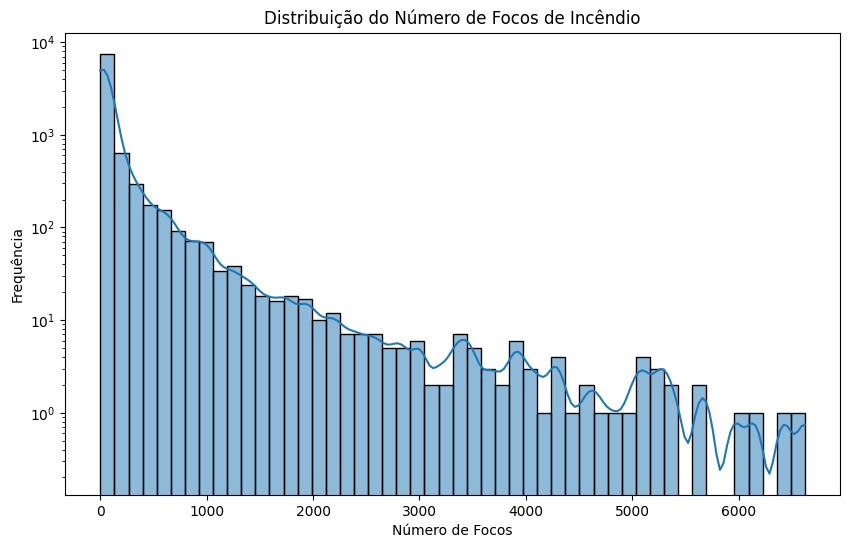

In [ ]:
# Distribution of 'focuses'
plt.figure(figsize=(10, 6))
sns.histplot(df['focuses'], bins=50, kde=True)
plt.title('Distribuição do Número de Focos de Incêndio')
plt.xlabel('Número de Focos')
plt.ylabel('Frequência')
plt.yscale('log') # Use log scale if distribution is heavily skewed
plt.show()

<ipython-input-48-3dddd751a369>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='focuses', data=focuses_per_year, palette="viridis")


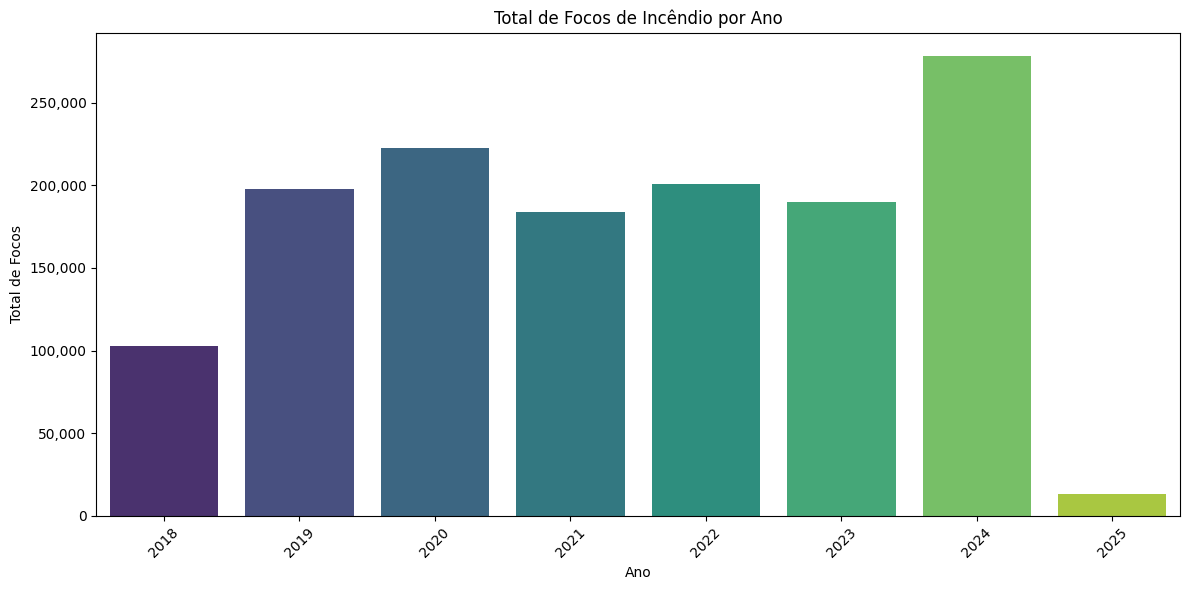

In [ ]:
# Total focuses per year
focuses_per_year = df.groupby('year')['focuses'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='focuses', data=focuses_per_year, palette="viridis")
plt.title('Total de Focos de Incêndio por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Focos')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

<ipython-input-49-ffede08e0be6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='focuses', data=focuses_per_month, palette="magma")


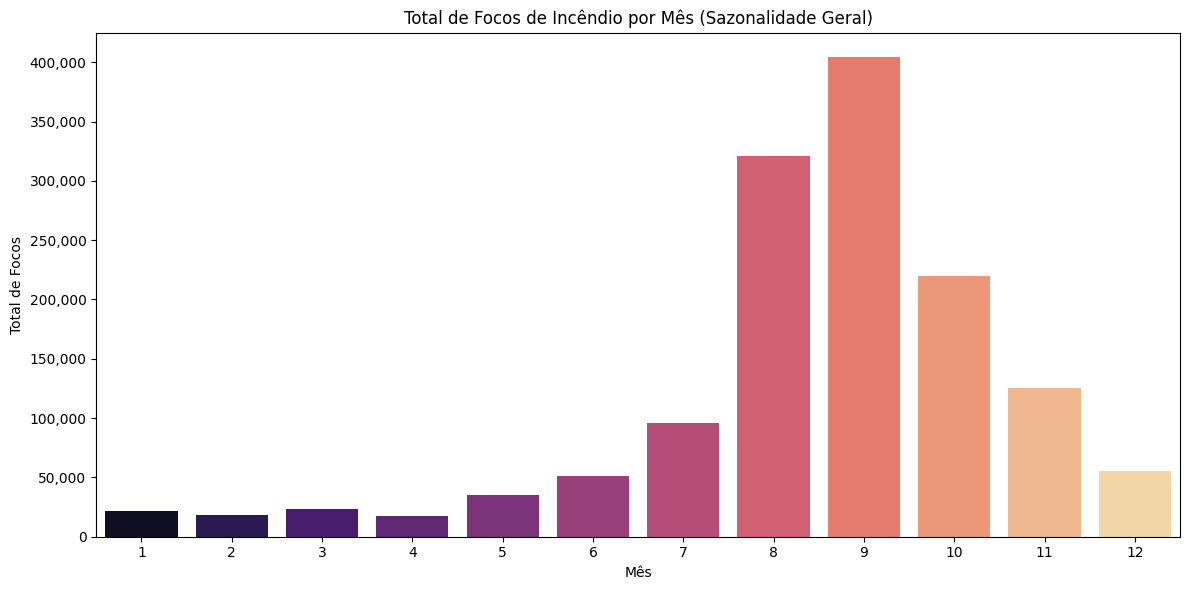

In [ ]:
# Total focuses per month (overall seasonality)
focuses_per_month = df.groupby('month')['focuses'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='focuses', data=focuses_per_month, palette="magma")
plt.title('Total de Focos de Incêndio por Mês (Sazonalidade Geral)')
plt.xlabel('Mês')
plt.ylabel('Total de Focos')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

<ipython-input-50-ef2fc030ea3f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='focuses', y='uf', data=top_states, palette="crest", orient='h')


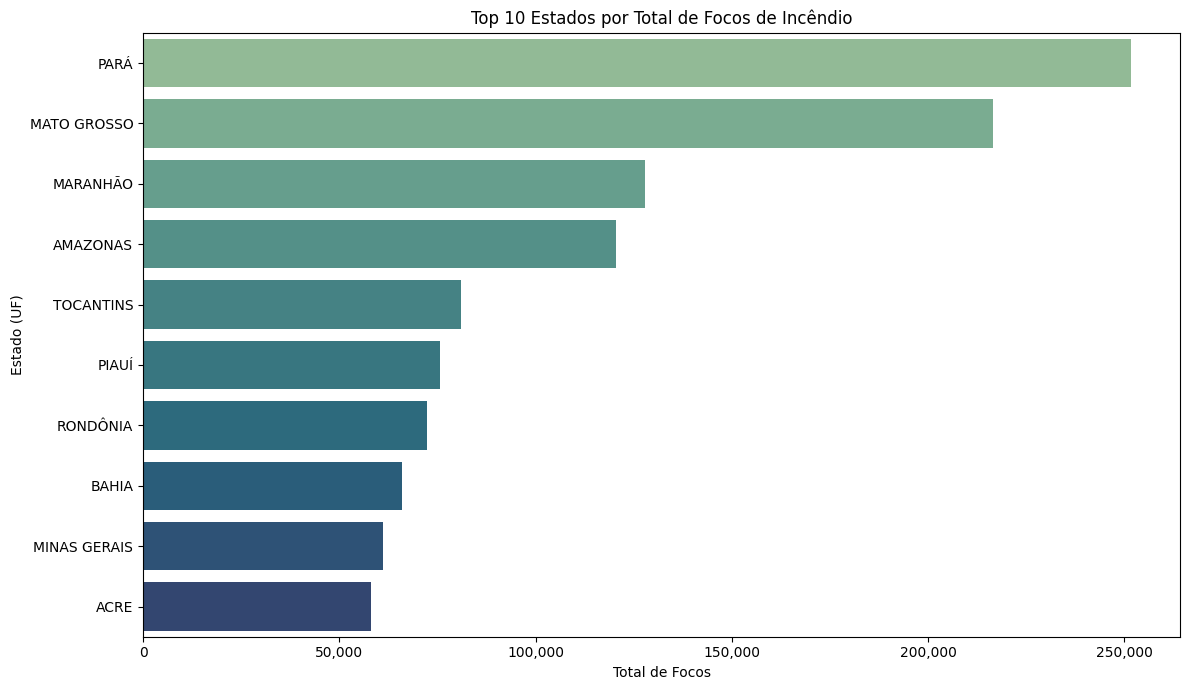

In [ ]:
# Top 10 States by total focuses
top_states = df.groupby('uf')['focuses'].sum().nlargest(10).reset_index()
plt.figure(figsize=(12, 7))
sns.barplot(x='focuses', y='uf', data=top_states, palette="crest", orient='h')
plt.title('Top 10 Estados por Total de Focos de Incêndio')
plt.xlabel('Total de Focos')
plt.ylabel('Estado (UF)')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

<ipython-input-51-328a5156c118>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='focuses', y='class', data=focuses_by_class, palette="flare", orient='h')


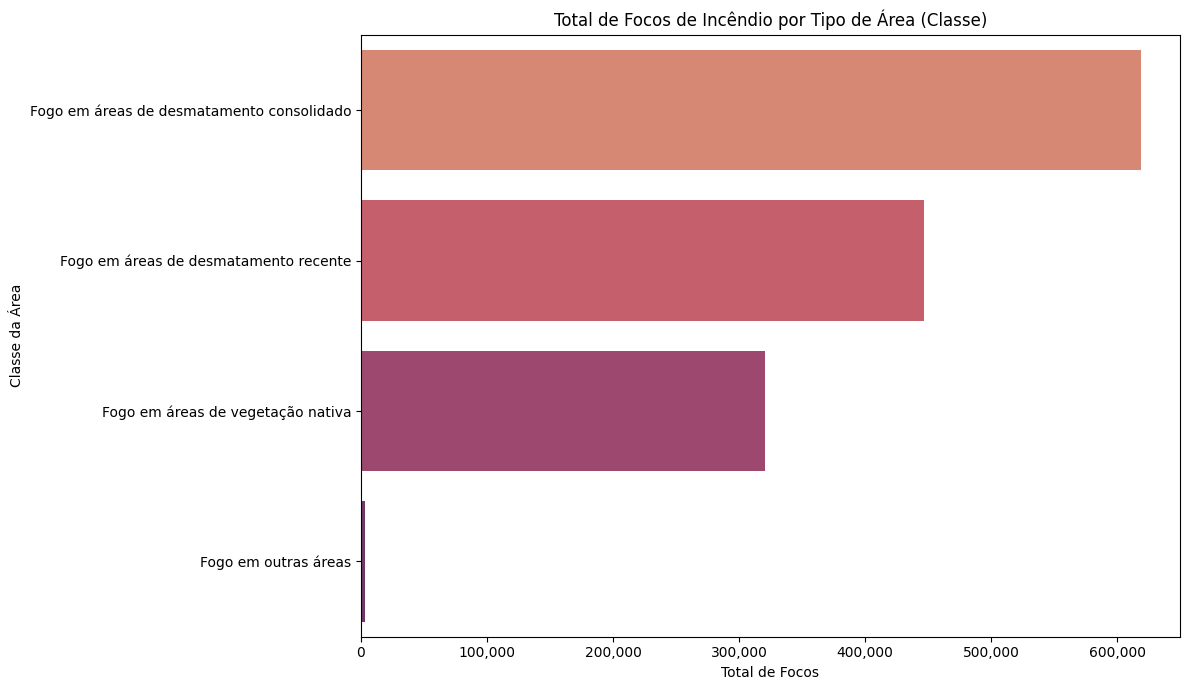

In [ ]:
# Focuses by 'class' (type of fire area)
focuses_by_class = df.groupby('class')['focuses'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 7))
sns.barplot(x='focuses', y='class', data=focuses_by_class, palette="flare", orient='h')
plt.title('Total de Focos de Incêndio por Tipo de Área (Classe)')
plt.xlabel('Total de Focos')
plt.ylabel('Classe da Área')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

<ipython-input-52-76943176e0f3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='focuses', data=df, palette="coolwarm")


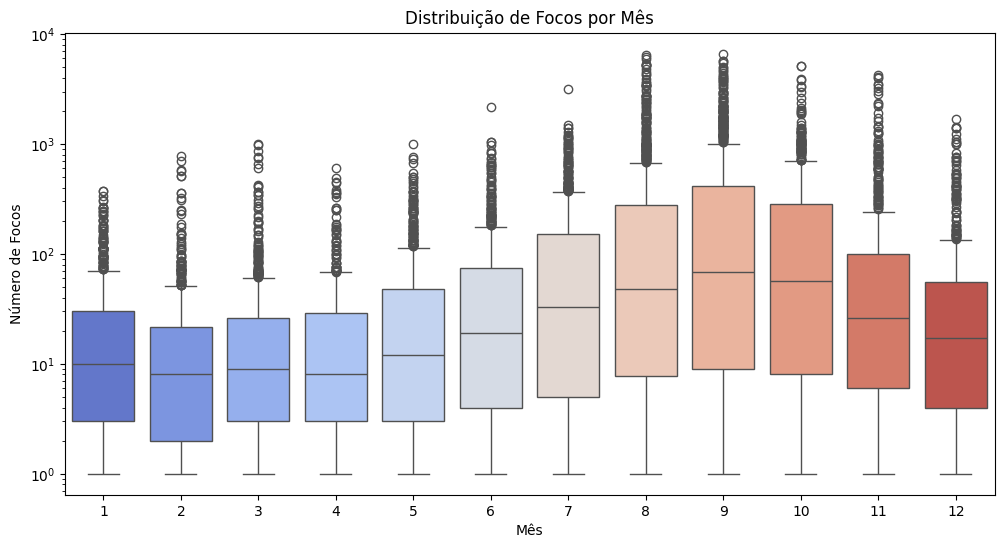

In [ ]:
# Boxplot of focuses by month to see distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='focuses', data=df, palette="coolwarm")
plt.title('Distribuição de Focos por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Focos')
plt.yscale('log') # Often useful for skewed data like counts
plt.show()



```
1.3. Modelagem (Machine Learning)
Objetivo: Prever o número de `focuses` (Regressão).
```



In [ ]:
# Define features (X) and target (y)
# 'date' column is dropped as 'year' and 'month' are extracted
X = df[['year', 'month', 'class', 'uf']]
y = df['focuses']

In [ ]:
# Identify categorical and numerical features
categorical_features = ['class', 'uf']
numerical_features = ['year', 'month'] # 'month' could also be cyclical, but treated as numeric here for simplicity

In [ ]:
# Preprocessing pipeline
# OneHotEncoder for categorical features
# StandardScaler for numerical features (though Random Forest is not very sensitive to feature scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), # sparse_output=False for easier handling later
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")

Formato de X_train: (7433, 4)
Formato de X_test: (1859, 4)


In [ ]:
# Create the full pipeline with the regressor
# Using RandomForestRegressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=5, min_samples_leaf=3))
])

In [ ]:
# Train the model
print("\n--- Treinando o Modelo ---")
model_pipeline.fit(X_train, y_train)
print("Treinamento concluído.")


--- Treinando o Modelo ---
Treinamento concluído.


In [ ]:
# Make predictions
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

In [ ]:
# Evaluate the model
print("\n--- Avaliação do Modelo ---")
print(f"MAE (Treino): {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"MAE (Teste): {mean_absolute_error(y_test, y_pred_test):.2f}")

print(f"MSE (Treino): {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"MSE (Teste): {mean_squared_error(y_test, y_pred_test):.2f}")

print(f"RMSE (Treino): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"RMSE (Teste): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")

print(f"R² (Treino): {r2_score(y_train, y_pred_train):.4f}")
print(f"R² (Teste): {r2_score(y_test, y_pred_test):.4f}") # This is the key metric for regression

# R-squared might not be super high if the relationship is very complex or noisy.
# Values can be very high, so MAE and RMSE in absolute terms are also important.


--- Avaliação do Modelo ---
MAE (Treino): 100.68
MAE (Teste): 128.26
MSE (Treino): 77493.34
MSE (Teste): 156731.40
RMSE (Treino): 278.38
RMSE (Teste): 395.89
R² (Treino): 0.6065
R² (Teste): 0.3504


<ipython-input-61-262b7cc1ceed>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis') # Top 20


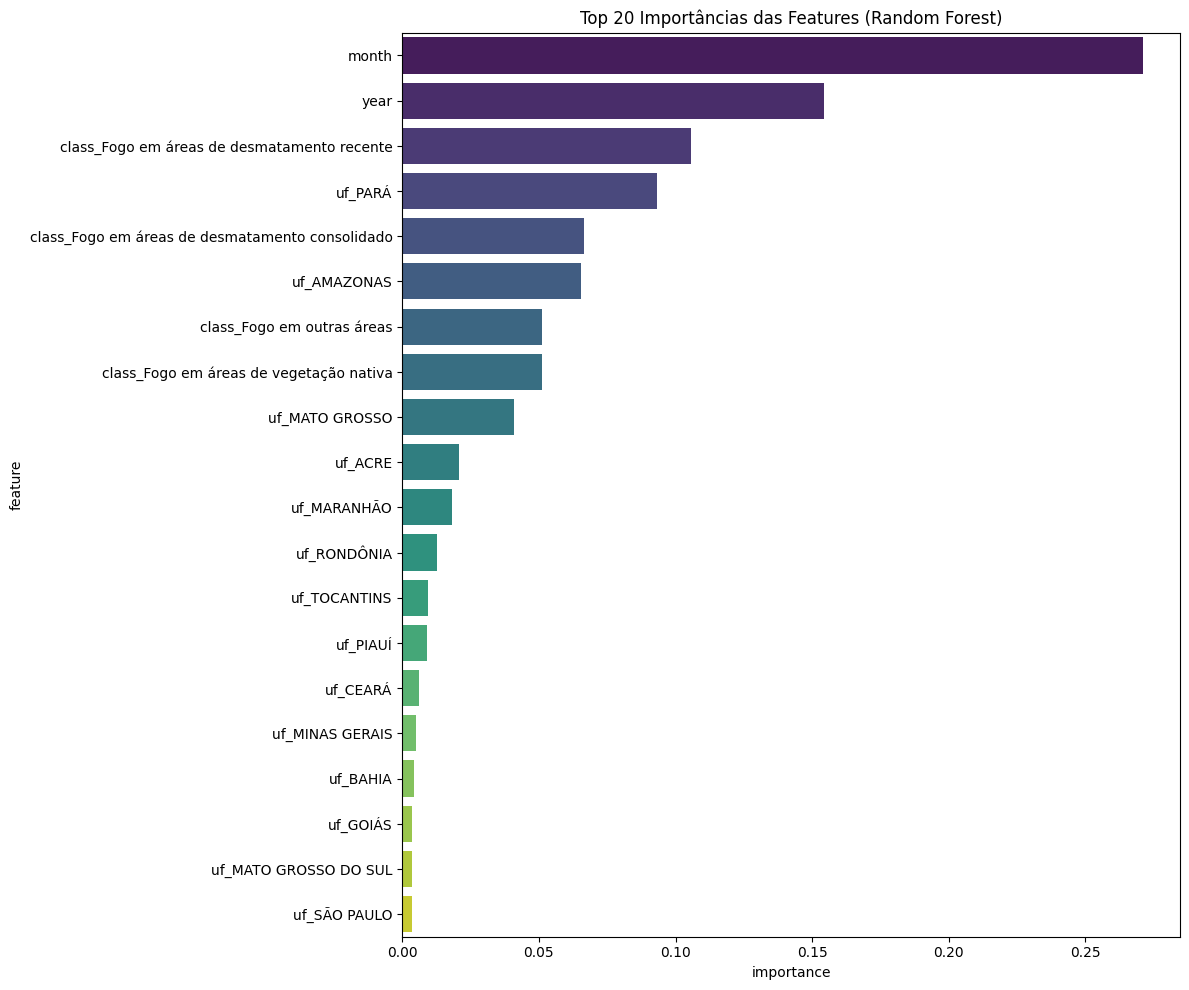

In [ ]:
# Feature Importances (if using tree-based models like RandomForest)
# Get feature names after one-hot encoding
try:
    onehot_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([onehot_feature_names, numerical_features])

    importances = model_pipeline.named_steps['regressor'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis') # Top 20
    plt.title('Top 20 Importâncias das Features (Random Forest)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Não foi possível gerar o gráfico de importância das features: {e}")

In [ ]:
# Save the trained model pipeline, and unique values for dropdowns in Streamlit
joblib.dump(model_pipeline, 'brazil_fire_focus_model.joblib')
joblib.dump(list(df['class'].unique()), 'unique_classes.joblib')
joblib.dump(list(df['uf'].unique()), 'unique_ufs.joblib')
joblib.dump(list(X.columns), 'model_feature_columns.joblib') # Original columns before preprocessing

print("\nModelo e listas de valores únicos salvos!")


Modelo e listas de valores únicos salvos!


In [ ]:
# Example of loading and predicting (for testing the saved artifacts)
loaded_model_pipeline = joblib.load('brazil_fire_focus_model.joblib')
unique_classes = joblib.load('unique_classes.joblib')
unique_ufs = joblib.load('unique_ufs.joblib')

In [ ]:
# Create a sample input DataFrame (must match the structure of X_train)
sample_input_dict = {
    'year': [2025],
    'month': [7], # Example: July
    'class': [unique_classes[0]], # Example: First class type
    'uf': [unique_ufs[0]] # Example: First UF
}
sample_input_df = pd.DataFrame(sample_input_dict)

In [ ]:
# Ensure column order is the same as during training
model_columns = joblib.load('model_feature_columns.joblib')
sample_input_df = sample_input_df[model_columns]


predicted_focuses = loaded_model_pipeline.predict(sample_input_df)
print(f"\nExemplo de predição com modelo carregado para {sample_input_df.iloc[0].to_dict()}:")
print(f"Focos previstos: {predicted_focuses[0]:.0f}")


Exemplo de predição com modelo carregado para {'year': 2025, 'month': 7, 'class': 'Fogo em áreas de desmatamento consolidado', 'uf': 'RIO GRANDE DO SUL'}:
Focos previstos: 85


In [ ]:
# Compare with an actual value from X_test if possible
print("\n--- Comparação com uma amostra do Teste ---")
sample_X_test = X_test.iloc[[0]]
true_y_test_sample = y_test.iloc[0]
predicted_y_test_sample = model_pipeline.predict(sample_X_test)[0]

print(f"Entrada de Teste: {sample_X_test.iloc[0].to_dict()}")
print(f"Focos Reais: {true_y_test_sample}")
print(f"Focos Previstos (Teste): {predicted_y_test_sample:.0f}")


--- Comparação com uma amostra do Teste ---
Entrada de Teste: {'year': 2020, 'month': 1, 'class': 'Fogo em áreas de desmatamento consolidado', 'uf': 'MATO GROSSO DO SUL'}
Focos Reais: 57
Focos Previstos (Teste): 33


```
Notebook concluído. Artefatos `brazil_fire_focus_model.joblib`, `unique_classes.joblib`, `unique_ufs.joblib`
e `model_feature_columns.joblib` estão prontos para serem usados no app Streamlit.


O dataset original `all_dashboard-fires-month-02-06-2025-22_23_57.csv` também será usado para análise descritiva.
```

